# 2020-11-30 • Sparse trains & KS exponential test

Going further on {doc}`/notebooks/2020-11-30__speedup`, here we actually try to replace full "0/1" spike trains spike index arrays, in the entire codebase.

Also, as a bonus, we test whether the inter-spike-intervals are really exponentially distributed (and hence the generated spike trains Poisson distibuted).

## Imports & time grid

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading:
 - numpy … (0.10 s)
 - matplotlib.pyplot … (0.23 s)
 - numba … (0.31 s)

Importing from submodules (compiling numba functions) … ✔

Imported `np`, `mpl`, `plt`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Mon 28 Dec** 2020, at 13:58 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/c9238595d01479470f1d4965446c1db53ecc3d12
) (Mon 28 Dec 2020, 13:54).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/__init__.py
 M codebase/voltage_to_wiring_sim/support/array_wrapper.py
A  notebooks/2020-11-11__unitlib.ipynb
MM notebooks/2020-11-30__speedup__spike_indices.ipynb
```

In [3]:
tg = v.TimeGrid(duration=10*minute, timestep=0.1*ms);

## Generate VI signal

### Spike trains

In [4]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

In [5]:
f_spike = 20 * Hz;

In [6]:
gen_st = v.generate_Poisson_spikes

v.fix_rng_seed()

In [7]:
%%time
spike_trains_connected = [gen_st(f_spike, tg.duration) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(f_spike, tg.duration) for _ in range(N_unconnected)];

Wall time: 14.3 ms


This was 1.77 seconds when generating full 0/1 signals. I.e. we got 10x speedup by switching to drawing ISI's from an exponential and only saving spike times.

In [8]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected;

In [9]:
time_slice = 1 * minute + np.array([0, 1]) * second

slice_indices = np.round(time_slice / tg.timestep).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.time[i_slice];

New eventplot function:

In [10]:
def plot_spike_train_excerpt(spike_train):
    return v.spike_trains.plot(spike_train, time_slice)

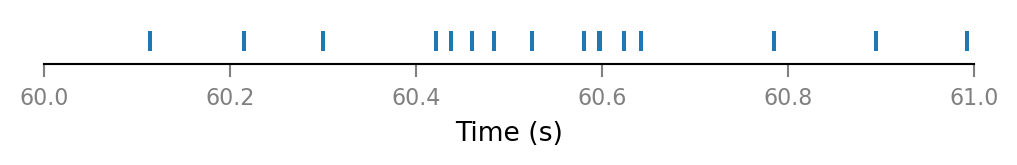

In [11]:
plot_spike_train_excerpt(all_spike_trains[0]);

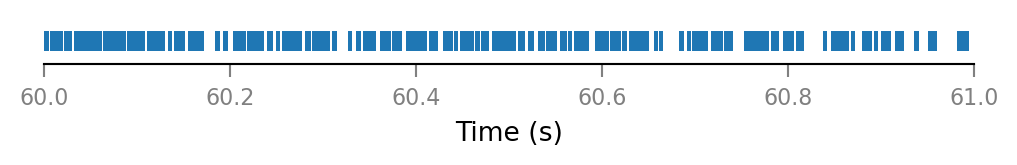

In [12]:
all_incoming_spikes = np.concatenate(spike_trains_connected)

plot_spike_train_excerpt(all_incoming_spikes);

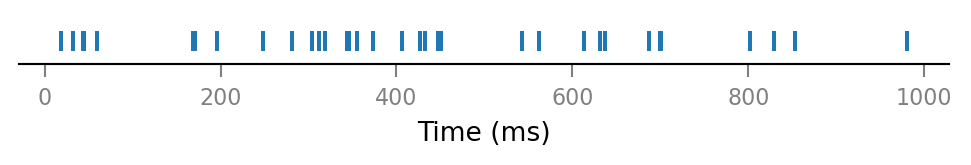

In [13]:
v.spike_trains.test()

### Test exponential distribution

Aight.

Check if spike train's are really Poisson; and thus that ISI's are exponentially distributed.

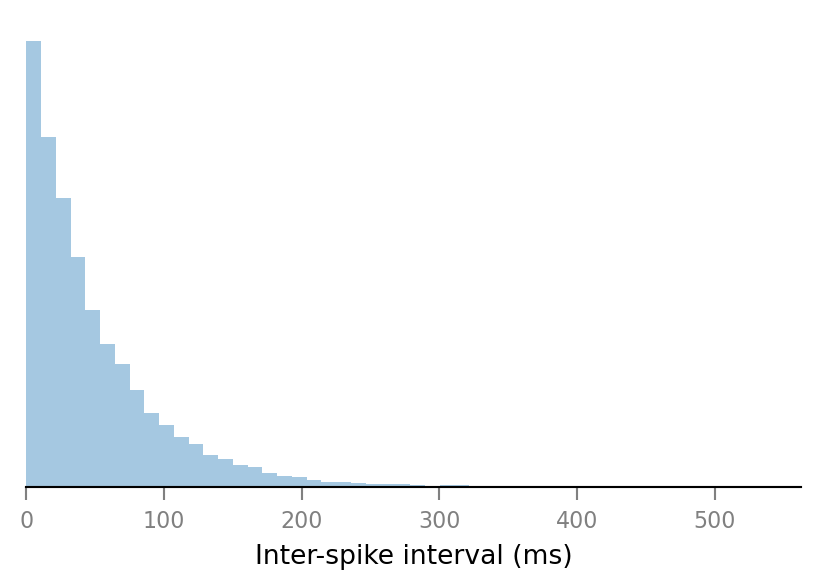

In [14]:
st = all_spike_trains[0]
ISIs = np.diff(st)

import seaborn as sns
ax = sns.distplot(ISIs / ms, kde=False, norm_hist=True)
ax.set_xlim(left=0)
ax.set_xlabel("Inter-spike interval (ms)")
ax.set_yticks([])
sns.despine(ax=ax, left=True);

Fit exponential:

In [15]:
from scipy.stats import expon

loc, scale = expon.fit(ISIs / ms)
loc, scale

(0.003623, 49.43)

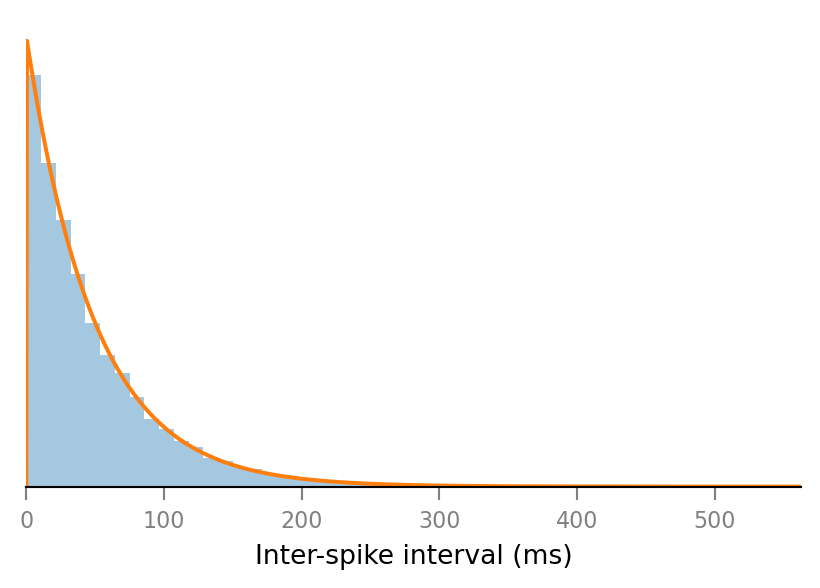

In [16]:
pdf = partial(expon.pdf, loc=loc, scale=scale)
x = np.linspace(*ax.get_xlim(), 1000)
ax.plot(x, pdf(x))
ax.figure

QQ plot

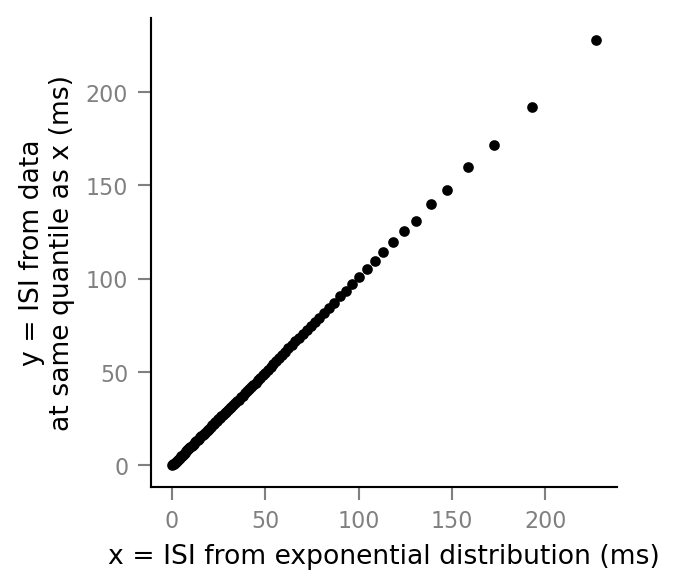

In [17]:
num_quantiles = 100  # i.e. we'll plot percentiles
quantiles = np.linspace(0, 1, num_quantiles)

fig, ax = plt.subplots()

for q in quantiles:
    x = expon.ppf(q, loc, scale)  # "ppf" = "percent point function" 
    #                             #       = inverse cdf = quantiles
    y = np.quantile(ISIs / ms, q)
    ax.plot(x, y, 'k.')

ax.set(
    aspect='equal',
    xlabel='x = ISI from exponential distribution (ms)',
    ylabel='y = ISI from data\n'
           'at same quantile as x (ms)'
);

Straight line: it fits 😮.

CDF comparison

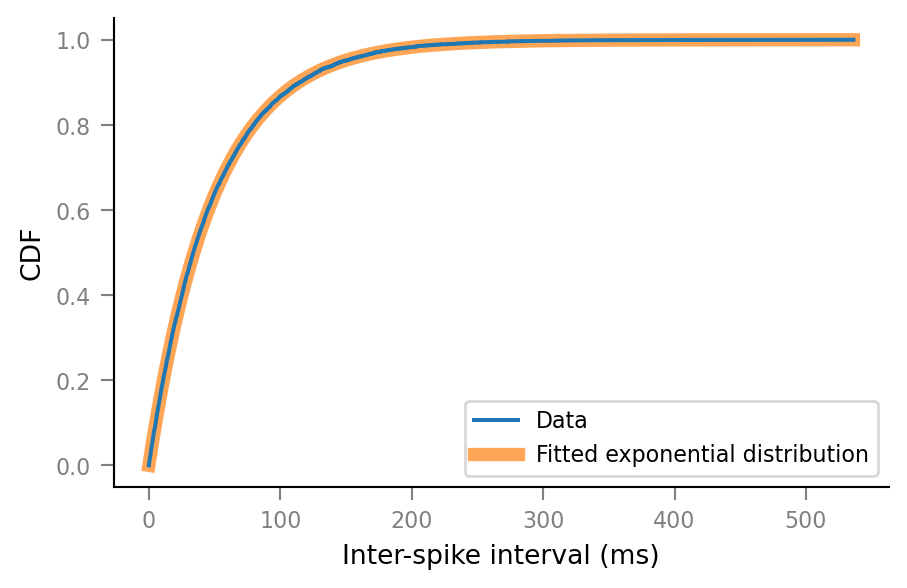

In [18]:
fig, ax = plt.subplots()

x_data = sorted_ISIs = np.sort(ISIs / ms)
y_data = np.linspace(0, 1, len(x_data))
ax.step(x_data, y_data, label="Data")

x_pdf = np.linspace(sorted_ISIs[0], sorted_ISIs[-1], 1000)
y_pdf = expon.cdf(x_pdf, loc, scale)
bg_kwargs = dict(alpha=0.7, lw=5, zorder=0)
ax.plot(x_pdf, y_pdf, label="Fitted exponential distribution", **bg_kwargs)

ax.set(
    xlabel="Inter-spike interval (ms)",
    ylabel="CDF",
)
ax.legend();

Zoom in:

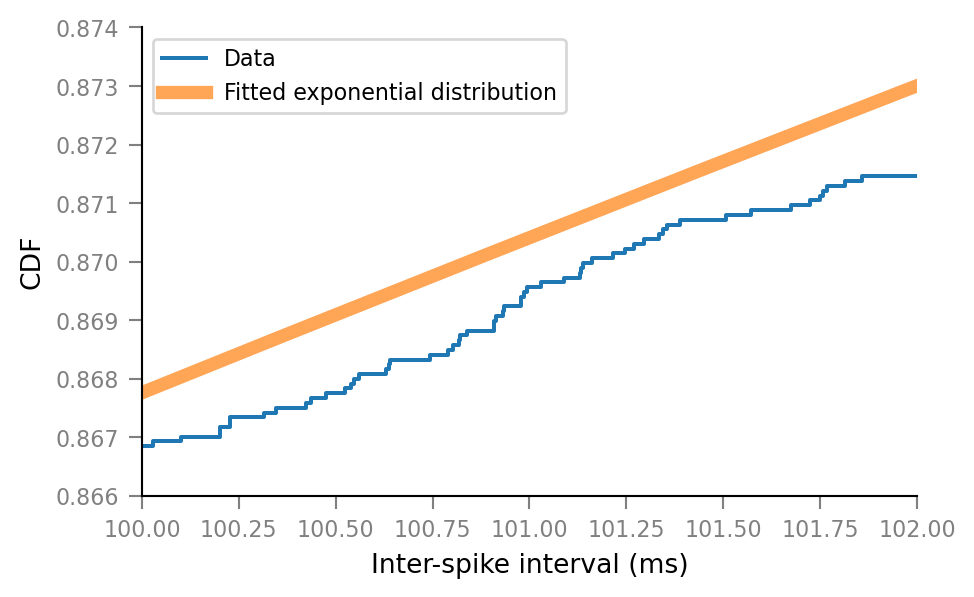

In [19]:
xlim_orig = ax.get_xlim()
ylim_orig = ax.get_ylim()
xlim_superzoom = (100, 102)
ylim_superzoom = (0.866, 0.874)
ax.set(xlim=xlim_superzoom, ylim=ylim_superzoom)
ax.figure

Combine zoomed views with original plot.

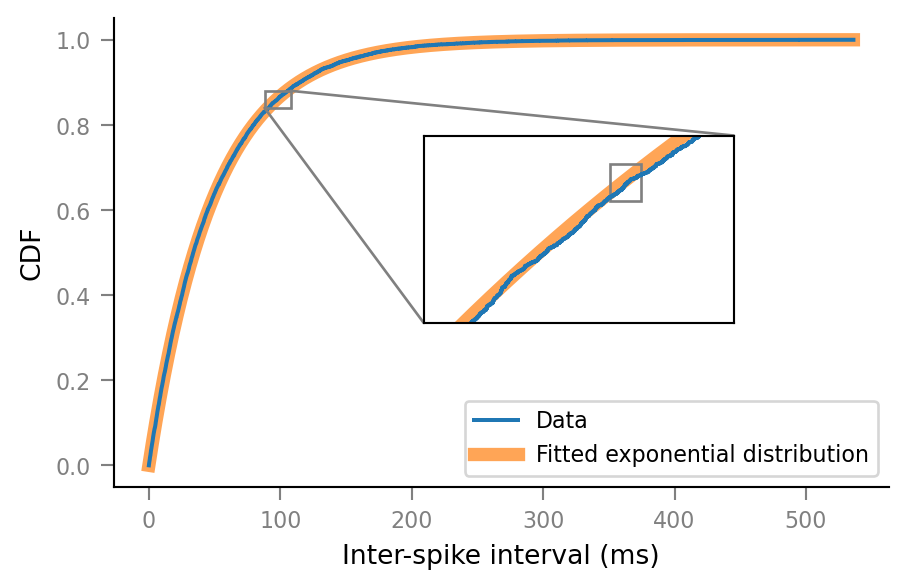

In [20]:
ax.set(xlim=xlim_orig, ylim=ylim_orig)
in_ax = ax.inset_axes([0.4, 0.35, 0.4, 0.4])
sns.despine(ax=in_ax, top=False, right=False)
in_ax.step(x_data, y_data)
in_ax.plot(x_pdf, y_pdf, **bg_kwargs)
xlim_medium_zoom = (88, 108)
ylim_medium_zoom = (0.84, 0.88)
in_ax.set(xlim=xlim_medium_zoom, ylim=ylim_medium_zoom)
ax.indicate_inset_zoom(in_ax, alpha=1)
in_ax.set_xticks([])
in_ax.set_yticks([])
# Mark superzoom of above _inside_ inset.
# 
# `in_ax.indicate_inset` doesn't work for some reason.
# Hence the manual Rectangle.
in_ax.add_patch(
    mpl.patches.Rectangle(
        xy=(xlim_superzoom[0], ylim_superzoom[0]),
        width=np.diff(xlim_superzoom).item(),
        height=np.diff(ylim_superzoom).item(),
        ec='grey',
        fill=False,
))
ax.figure

Quantify distance between CDF's with (two-sided) Kolmogorov-Smirnov test.

KS test statistic is maximum vertical distance between CDF's.\
p-value is calculated based on this statistic and the [Kolmogorov distribution](https://www.wikiwand.com/en/Kolmogorov%E2%80%93Smirnov_test#/Kolmogorov_distribution)
([SciPy implementation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ksone.html#scipy.stats.ksone))
-- which in turn is based on Brownian motion i.e. random walks.

In [21]:
from scipy.stats import kstest
kstest(ISIs / ms, expon.cdf, (loc, scale))

KstestResult(statistic=0.005775131258583199, pvalue=0.8107313119920425)

We reject H1 that the data is not drawn from an exponential distribution ($p \gg 0.05$).

Addendum: this statistical analysis is not entirely correct, 
because the KS test assumes that the parameters of the probability distribution
are not determined from the data (as we have done here).
Some correction to the statistic/p-value would be needed to correct for that

### Synaptic conductance

In [14]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms;

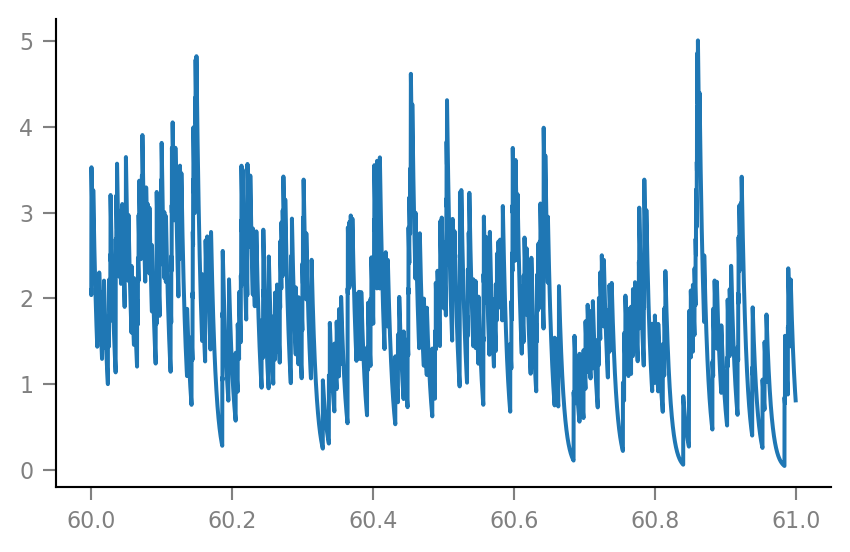

In [15]:
g_syn = v.calc_synaptic_conductance(tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice] / nS);

### Membrane voltage

In [16]:
params = v.params.cortical_RS
v.pprint(params)

IzhikevichParams
----------------
C = 1e-10
k = 7e-07
v_r = -0.06
v_t = -0.04
v_peak = 0.035
a = 30.0
b = -2e-09
c = -0.05
d = 1e-10
v_syn = 0.0


In [17]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 228 ms


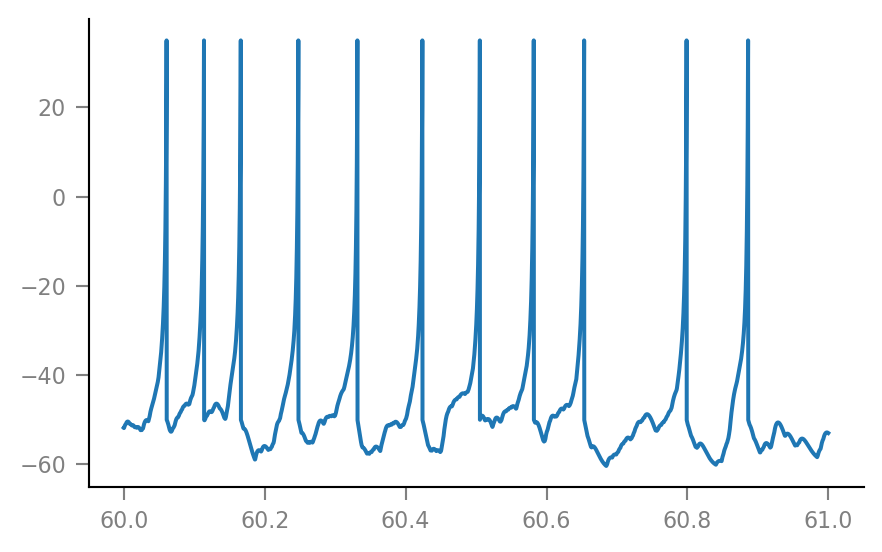

In [18]:
plt.plot(t_slice / second, sim.V_m[i_slice] / mV);

### Imaging model

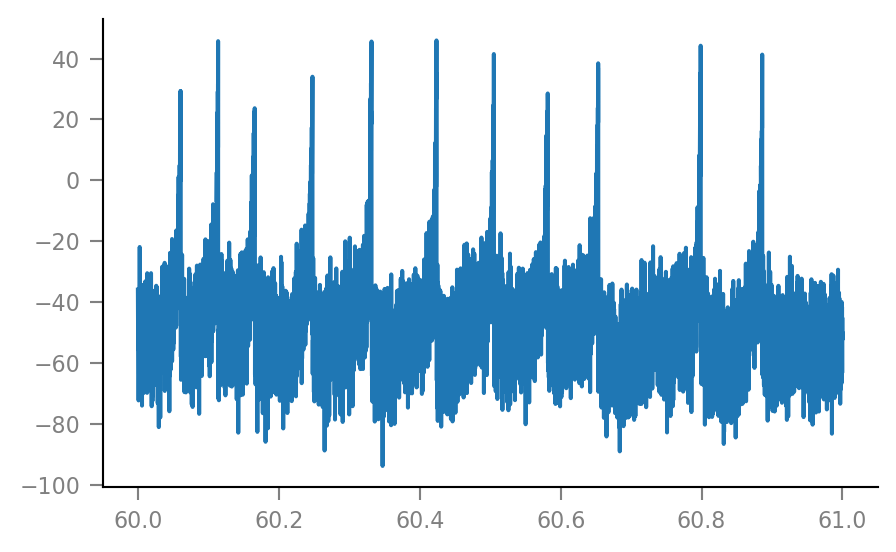

In [19]:
Vm_noisy = v.add_VI_noise(sim.V_m, params)

plt.plot(t_slice / second, Vm_noisy[i_slice] / mV);

## Shuffle one spike train

We choose one spike train / incoming neuron, and will test the hypothesis that this neuron is connected to the simulated neuron.
- H0 = neuron of incoming spike train is not connected to simulated neuron
- H1 = they _are_ connected

In [20]:
spike_train = all_spike_trains[0];

In [47]:
test_result = v.test_connection(spike_train, Vm_noisy, window_duration=100 * ms, num_shuffles=100);

In [65]:
v.pprint(test_result)

ConnectionTestResult
--------------------
shuffled_spike_trains = [array([0.0142..., 599.8, 600]), array([0.0341..., 599.9, 600]), array([0.0095..., 599.9, 600]), array([0.0305..., 599.9, 600]), array([0.0447..., 599.9, 600]), array([0.0636..., 599.9, 600]), ...]
original_train_STA_max = -0.04576
shuffled_trains_STA_max = array([-0.047...52, -0.04753])
p_value = 0.01
p_value_type = '<'
mean_shuffled_STA_max = -0.0475
original_vs_shuffled_STA_max = 0.9633


In [69]:
format(test_result.mean_shuffled_STA_max, ".4G")

'-0.0475'

Inspect a few shuffled spike trains.

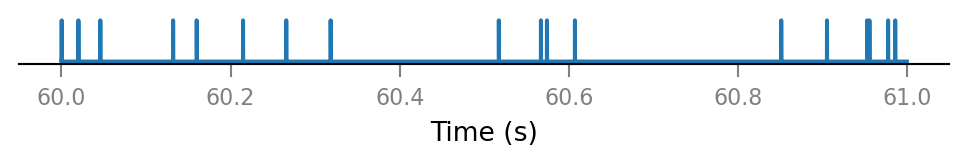

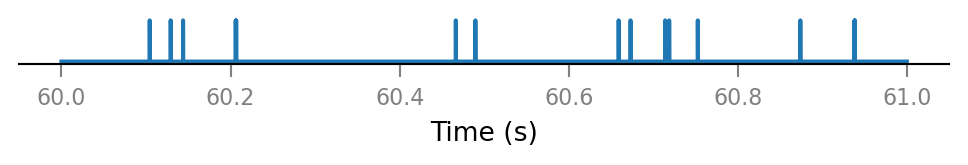

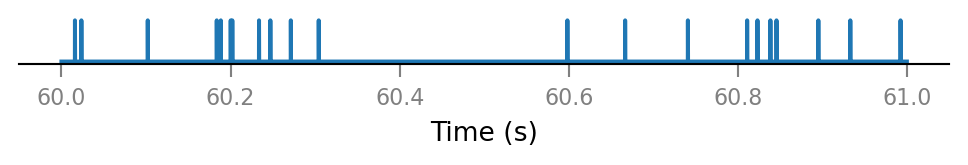

In [73]:
for i in range(3):
    plot_spike_train_excerpt(shuffled_spike_trains[i]);

Real spike train again:

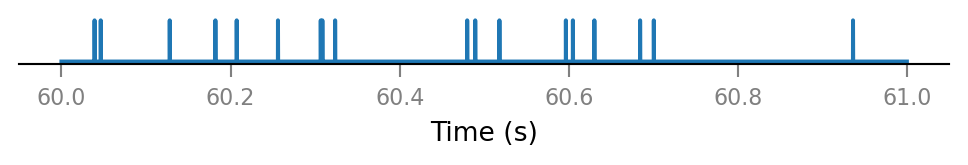

In [78]:
plot_spike_train_excerpt(spike_train);

Same number of spikes in all:

In [80]:
for i in range(3):
    print(len(shuffled_spike_trains[i]))

12020
12020
12020


In [82]:
num_spikes(spike_train)

12020

In [84]:
len(shuffled_spike_ix_[0])

12020

Spiking frequency of the chosen presynaptic neuron:

In [27]:
num_spikes(spike_train) / tg.T / Hz

20.03

That's to spec.

## Spike-triggered windowing & averaging

For each spike train (original and shuffleds), we extract spike-triggered windows from the simulated voltage imaging signal, and average those windows.

In [85]:
window_length = 100 * ms;

In [86]:
window_tg = v.TimeGrid(window_length, tg.dt);

In [87]:
def calc_STA(spike_train):
    return v.calculate_STA(Vm_noisy, spike_train, tg, window_tg)

In [88]:
original_STA = calc_STA(spike_train);

In [89]:
%%time
shuffled_STAs = []
for train in shuffled_spike_trains:
    shuffled_STAs.append(calc_STA(train))

Wall time: 8.36 s


Now with numba JIT'ted `make_windows`:

In [99]:
%%prun -D temp.profile
shuffled_STAs = []
for train in shuffled_spike_trains:
    shuffled_STAs.append(calc_STA(train))

 
*** Profile stats marshalled to file 'temp.profile'. 


(Time was like 6.4 seconds).

Now with creating 2D ndarray directly, instead of Python list of arrays:

(pure python:)

In [111]:
%%time
shuffled_STAs = []
for train in shuffled_spike_trains:
    shuffled_STAs.append(calc_STA(train))

Wall time: 7.75 s


(njit):

In [112]:
%%time
shuffled_STAs = []
for train in shuffled_spike_trains:
    shuffled_STAs.append(calc_STA(train))

Wall time: 5.11 s


In [113]:
%%prun -D temp.profile2
shuffled_STAs = []
for train in shuffled_spike_trains:
    shuffled_STAs.append(calc_STA(train))

 
*** Profile stats marshalled to file 'temp.profile2'. 


Don't create windows list; calc mean (sum) immediately:

In [116]:
%%time
shuffled_STAs = []
for train in shuffled_spike_trains:
    shuffled_STAs.append(calc_STA(train))

Wall time: 725 ms


In [118]:
%%prun -D temp.profile3
shuffled_STAs = []
for train in shuffled_spike_trains:
    shuffled_STAs.append(calc_STA(train))

 
*** Profile stats marshalled to file 'temp.profile3'. 


Ok, this is good improvement.

If we now also get rid of full spike trains and replace them with spike indices, we're good.

(0.4 s in njitted direct `_calc_STA`, 0.3 s in np.nonzero (i.e. `v.get_spike_indices`).

## Repro info

In [119]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Mon 30 Nov** 2020, at 15:13 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/48f883a909295f924ed704cd77a6d0367217feb8
) (Mon 30 Nov 2020, 14:39).

Uncommited changes to:
```
 M codebase/voltage_to_wiring_sim/STA.py
A  notebooks/2020-11-11__unitlib.ipynb
?? notebooks/2020-11-30__speedup.ipynb
?? notebooks/temp.profile
?? notebooks/temp.profile2
?? notebooks/temp.profile3
```

Platform:

Windows-10
CPython 3.8.3 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.2
numba                0.51.2
seaborn              0.10.1
scipy                1.5.2
scikit-learn         0.23.2
preload              2.1
py-cpuinfo           7.0.0
